     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 989.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 20.5 MB/s eta 0:00:00
Creating directory /root/.config/bioservices 
Fetching full list of human pathways from KEGG...
Creating directory /root/.cache/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /root/.config/bioservices/

,Gene,Frequency,Pathways
378,MAPK1,16,"Pathways in cancer, MicroRNAs in cancer, Prote..."
181,MAPK3,16,"Pathways in cancer, MicroRNAs in cancer, Prote..."
308,PIK3R1,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."
316,KRAS,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."
280,P3R3URF-PIK3R3,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."
303,PIK3R3,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."
314,TP53,15,"Pathways in cancer, Transcriptional misregulat..."
167,PIK3CB,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."
253,PIK3CD,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."
357,MAP2K1,15,"Pathways in cancer, MicroRNAs in cancer, Prote..."



Generating enhanced network visualization...


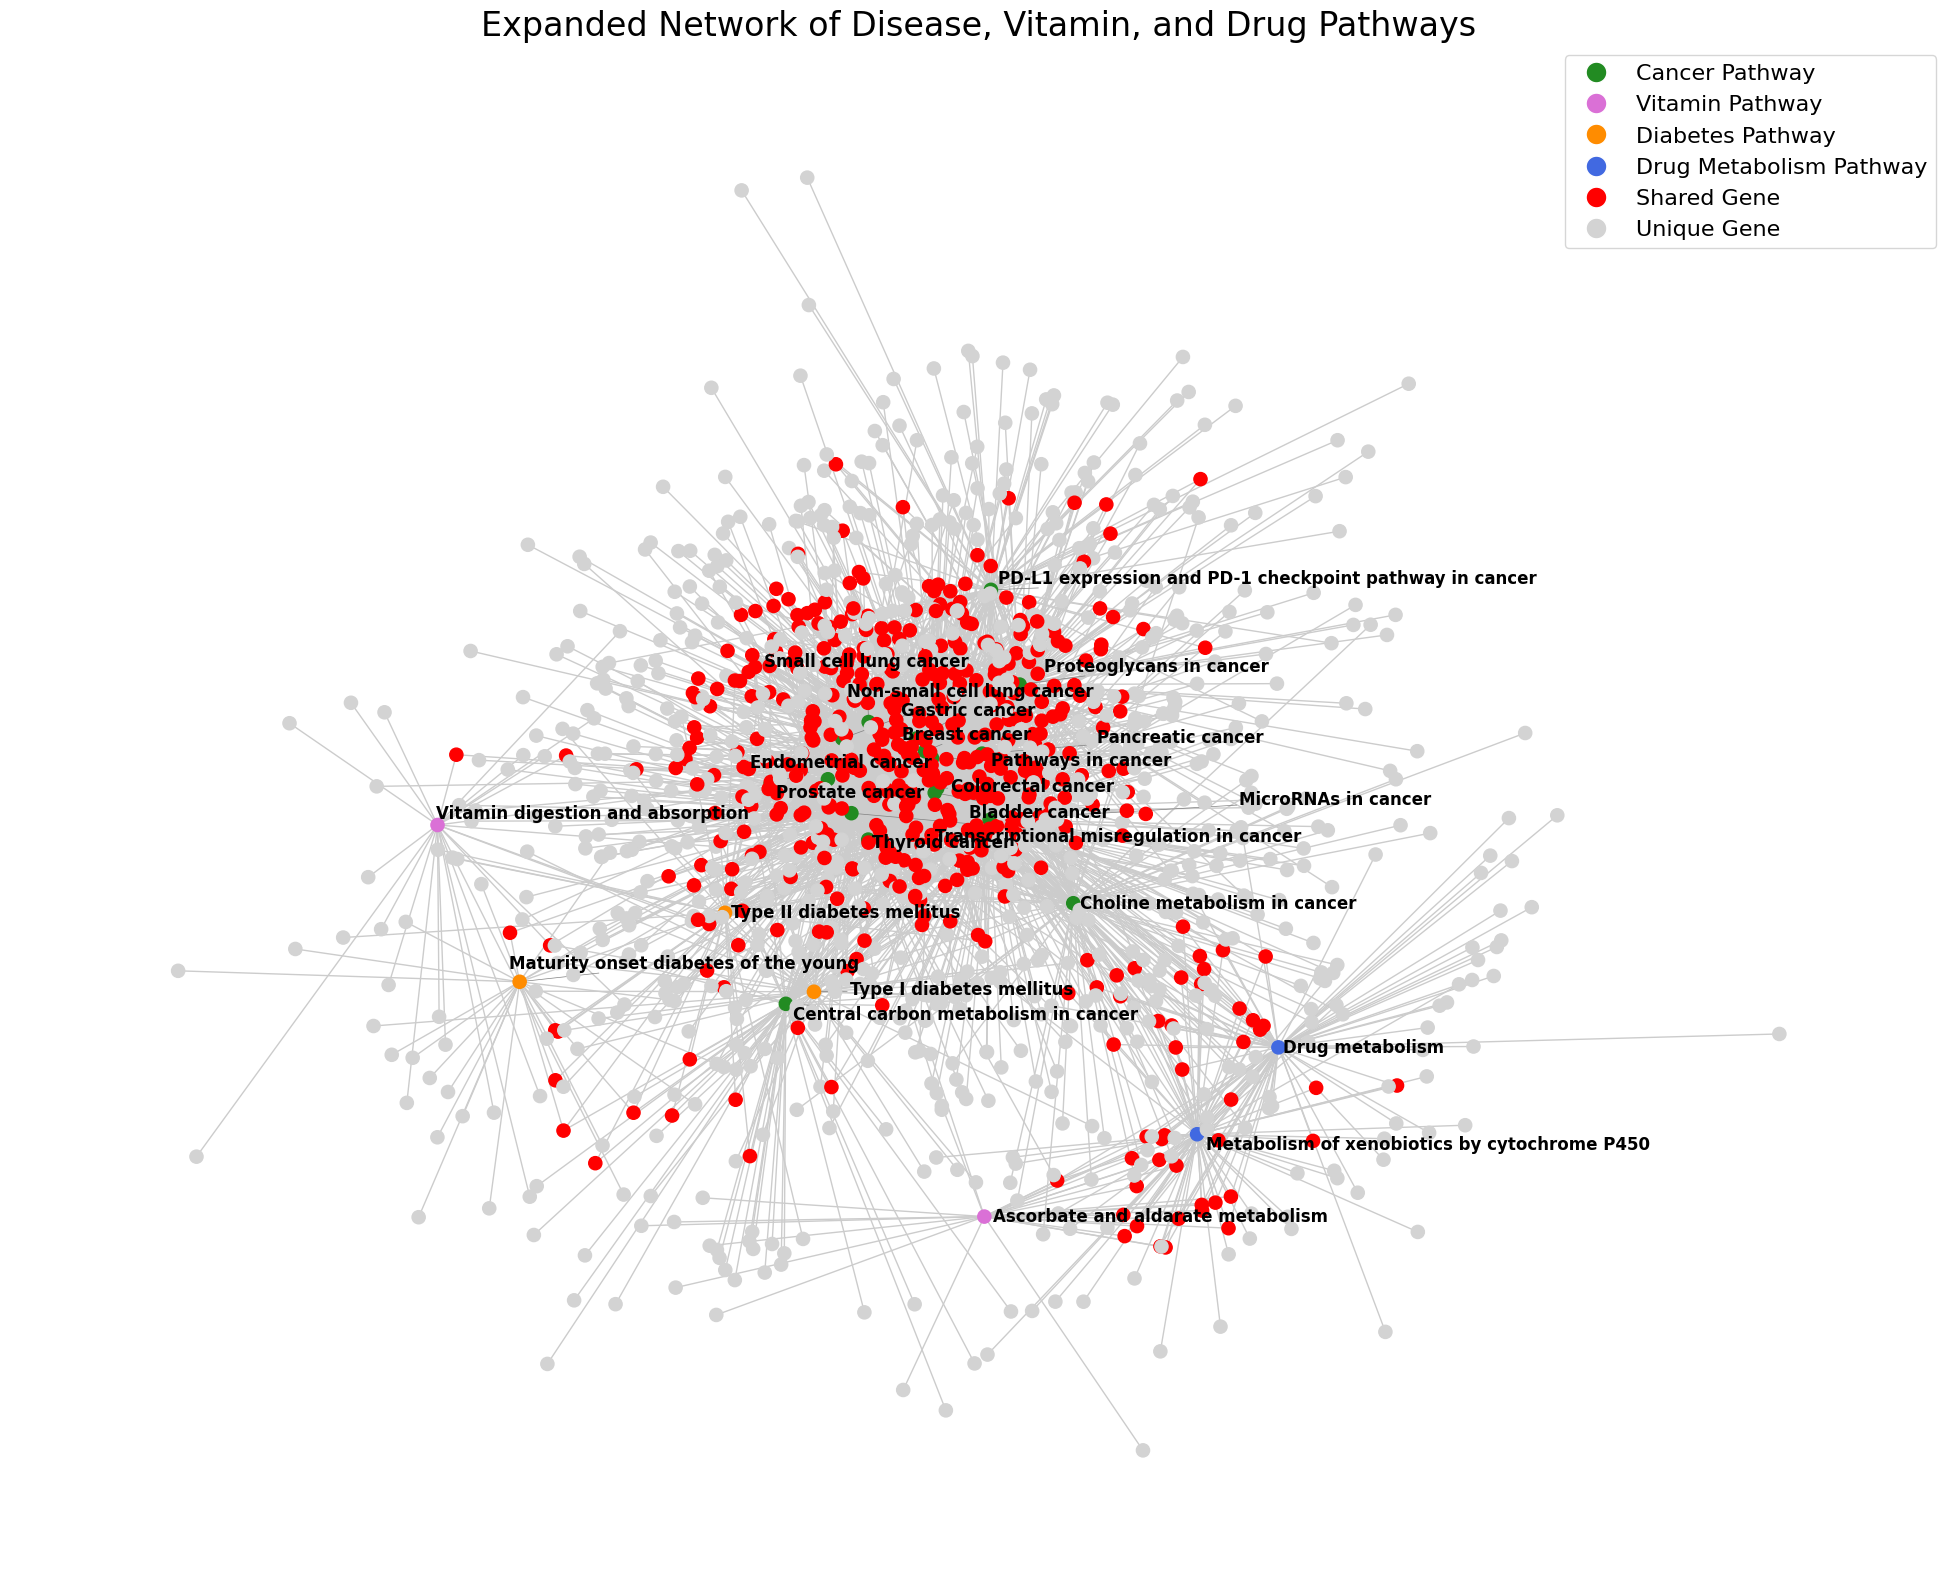

In [1]:

!pip install bioservices networkx matplotlib pandas adjustText


import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from bioservices import KEGG
from IPython.display import display
from adjustText import adjust_text
import re


def get_all_kegg_pathways():

    print("Fetching full list of human pathways from KEGG...")
    try:
        k = KEGG()
        pathways_raw = k.list("pathway/hsa")
        pathway_dict = {}
        for line in pathways_raw.strip().split('\n'):
            path_id, name_desc = line.split('\t')
            name = name_desc.split(' - ')[0]
            clean_id = path_id.replace('path:', '')
            pathway_dict[name] = clean_id
        print(f"-> Found {len(pathway_dict)} total pathways.")
        return pathway_dict
    except Exception as e:
        print(f"Error fetching pathway list: {e}")
        return None

def get_genes(pathway_id):

    try:
        k = KEGG()
        k.organism = "hsa"
        raw_data = k.get(pathway_id)
        if not raw_data: return set()
        genes = set()
        record = False
        for line in raw_data.strip().split('\n'):
            if line.startswith('GENE'):
                record = True
                line_content = line[12:].strip()
            elif record and line.startswith(' '):
                line_content = line.strip()
            else:
                record = False
                continue
            if line_content:
                parts = line_content.split()
                if len(parts) > 1 and parts[0].isdigit():
                    genes.add(parts[1].replace(';', ''))
        return genes
    except Exception as e:
        print(f"Error fetching genes for {pathway_id}: {e}")
        return set()


all_pathways = get_all_kegg_pathways()

if all_pathways:

    keywords = ['cancer', 'ascorbate', 'vitamin d', 'diabetes', 'drug metabolism', 'xenobiotics', 'fluoropyrimidine']
    filtered_pathways = {
        name: pid for name, pid in all_pathways.items()
        if any(keyword in name.lower() for keyword in keywords)
    }
    print(f"\nFiltering for pathways containing: {keywords}")
    print(f"-> Found {len(filtered_pathways)} relevant pathways for analysis.")

    print("\nFetching gene data for filtered pathways...")
    pathway_genes_map = {name: get_genes(pid) for name, pid in filtered_pathways.items()}

    print("\nAnalyzing gene overlaps...")
    all_genes_flat = [gene for sublist in pathway_genes_map.values() for gene in sublist]
    gene_counts = Counter(all_genes_flat)
    shared_genes = {gene: count for gene, count in gene_counts.items() if count >= 2}

    shared_gene_data = []
    for gene, frequency in shared_genes.items():

        member_of_pathways = [name for name, genes in pathway_genes_map.items() if gene in genes]
        shared_gene_data.append({
            'Gene': gene,
            'Frequency': frequency,
            'Pathways': ', '.join(member_of_pathways)
        })

    df_shared_enhanced = pd.DataFrame(shared_gene_data)
    df_shared_enhanced = df_shared_enhanced.sort_values(by='Frequency', ascending=False)

    print("\nPreview of the top 20 most frequently shared genes with their associated pathways:")
    display(df_shared_enhanced.head(20))

    print("\nGenerating enhanced network visualization...")
    G = nx.Graph()


    def get_pathway_category(name):
        name_lower = name.lower()
        if 'cancer' in name_lower: return 'Cancer', 'forestgreen'
        if 'vitamin' in name_lower or 'ascorbate' in name_lower: return 'Vitamin', 'orchid'
        if 'diabetes' in name_lower: return 'Diabetes', 'darkorange'
        if any(k in name_lower for k in ['drug', 'xenobiotics', 'fluoropyrimidine']): return 'Drug Metabolism', 'royalblue'
        return 'Other', 'gray'

    node_colors = {}
    for name in pathway_genes_map.keys():
        category, color = get_pathway_category(name)
        G.add_node(name, type='pathway', category=category)
        node_colors[name] = color
    for gene, count in gene_counts.items():
        G.add_node(gene, type='gene')
        node_colors[gene] = 'red' if count > 1 else 'lightgray'


    for name, genes in pathway_genes_map.items():
        for gene in genes:
            G.add_edge(name, gene)


    fig, ax = plt.subplots(figsize=(25, 20))
    pos = nx.spring_layout(G, k=0.6, iterations=50, seed=42)
    nx.draw(G, pos, ax=ax, with_labels=False, node_color=[node_colors[n] for n in G.nodes()], node_size=90, edge_color='#cccccc')

    pathway_labels = {n: n for n in G.nodes if G.nodes[n]['type'] == 'pathway'}
    texts = [ax.text(pos[n][0], pos[n][1], text, fontsize=12, fontweight='bold') for n, text in pathway_labels.items()]
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))


    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Cancer Pathway', markerfacecolor='forestgreen', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label='Vitamin Pathway', markerfacecolor='orchid', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label='Diabetes Pathway', markerfacecolor='darkorange', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label='Drug Metabolism Pathway', markerfacecolor='royalblue', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label='Shared Gene', markerfacecolor='red', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label='Unique Gene', markerfacecolor='lightgray', markersize=15)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

    plt.title("Expanded Network of Disease, Vitamin, and Drug Pathways", fontsize=24)
    plt.show()